Here we check if drivers identified by models overlap DNase1 footprints identified by Vierstra et al. 2020. 

In [56]:
import os
import sys
from collections import defaultdict

import liftover
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from genomic_utils.variant import Variant

sys.path.append("..")
import evaluation_utils

In [43]:
FOOTPRINT_DIRS = [
    "/data/yosef3/scratch/ruchir/data/vierstra2020/per_dataset/GM06990-DS7748",
    "/data/yosef3/scratch/ruchir/data/vierstra2020/per_dataset/GM12865-DS12436",
] # one directory per sample
FPR_THRESHOLD = "0.01"

LIFTOVER_CHAIN_PATH = "/data/yosef3/scratch/ruchir/data/genomes/liftOver/hg19ToHg38.over.chain.gz"

DRIVERS_CSV = "drivers.csv"

In [11]:
class Region():
    def __init__(self, chrom: str, start: int, end: int):
        self.chrom = chrom.replace("chr", "")
        self.start = int(start) # inclusive, 0-indexed
        self.end = int(end) # exclusive, 1-indexed
    
    def overlaps_variant(self, variant: Variant) -> bool:
        if self.chrom != variant.chrom:
            return False
        # variant.pos is 1-indexed
        return self.start < variant.pos <= self.end

In [16]:
def get_footprints_by_chromosome() -> dict[str, set[Region]]:
    footprints_by_chrom = defaultdict(set)
    for footprint_dir in FOOTPRINT_DIRS:
        bed_path = os.path.join(footprint_dir, f"interval.all.fps.{FPR_THRESHOLD}.bed")
        for line in open(bed_path):
            chrom, start, end, *_ = line.strip().split("\t")
            region = Region(chrom, start, end)
            footprints_by_chrom[region.chrom].add(region)
    return footprints_by_chrom

In [44]:
footprints_by_chrom = get_footprints_by_chromosome()

In [64]:
drivers_df = pd.read_csv(DRIVERS_CSV)
drivers_df["hg19_driver"] = drivers_df["driver"].apply(Variant.create_from_str)

# Liftover to hg38
converter = liftover.ChainFile(LIFTOVER_CHAIN_PATH, one_based=True)
hg38_drivers = []
for hg19_driver in drivers_df["hg19_driver"]:
    hg38_liftover = converter[hg19_driver.chrom][hg19_driver.pos]
    if len(hg38_liftover) == 0:
        hg38_drivers.append(None)
        print(f"WARNING: {hg19_driver} could not be lifted over")
    else:
        assert len(hg38_liftover) == 1
        (hg38_chrom, hg38_pos, _) = hg38_liftover[0]
        # Our analysis does not require knowing the ref/alt bases in hg38, so we can just use the hg19 ones
        hg38_driver = Variant(hg38_chrom, hg38_pos, hg19_driver.ref, hg19_driver.alt)
        hg38_drivers.append(hg38_driver)

drivers_df["hg38_driver"] = hg38_drivers

# Check if driver variants overlap footprints
def driver_overlaps_footprints(driver: Variant) -> bool:
    if driver is None:
        return False
    if driver.chrom not in footprints_by_chrom:
        return False
    for footprint in footprints_by_chrom[driver.chrom]:
        if footprint.overlaps_variant(driver):
            return True
    return False

overlaps_footprints = []
for driver in tqdm(drivers_df["hg38_driver"]):
    overlaps_footprints.append(driver_overlaps_footprints(driver))
drivers_df["overlaps_footprint"] = overlaps_footprints

# Annotate genes with their class
gene_to_class_map = evaluation_utils.get_gene_to_class_map()
drivers_df["gene_class"] = drivers_df["gene"].map(gene_to_class_map)
drivers_df["gene_class"] = drivers_df["gene_class"].map({"random_split": "Random-split", "yri_split": "Population-split"})

  0%|          | 0/4982 [00:00<?, ?it/s]

In [65]:
# Print the mean fraction of drivers overlapping footprints by model
for model in drivers_df["model"].unique():
    print(f"{model}: {drivers_df[drivers_df['model'] == model]['overlaps_footprint'].mean()}")

Top SNP: 0.028350515463917526
LASSO: 0.03231597845601436
Elastic net/
PrediXcan: 0.02920723226703755
BLUP: 0.027237354085603113
BSLMM: 0.0242024202420242
Baseline Enformer: 0.1633587786259542
Fine-tuned Enformer: 0.10330578512396695


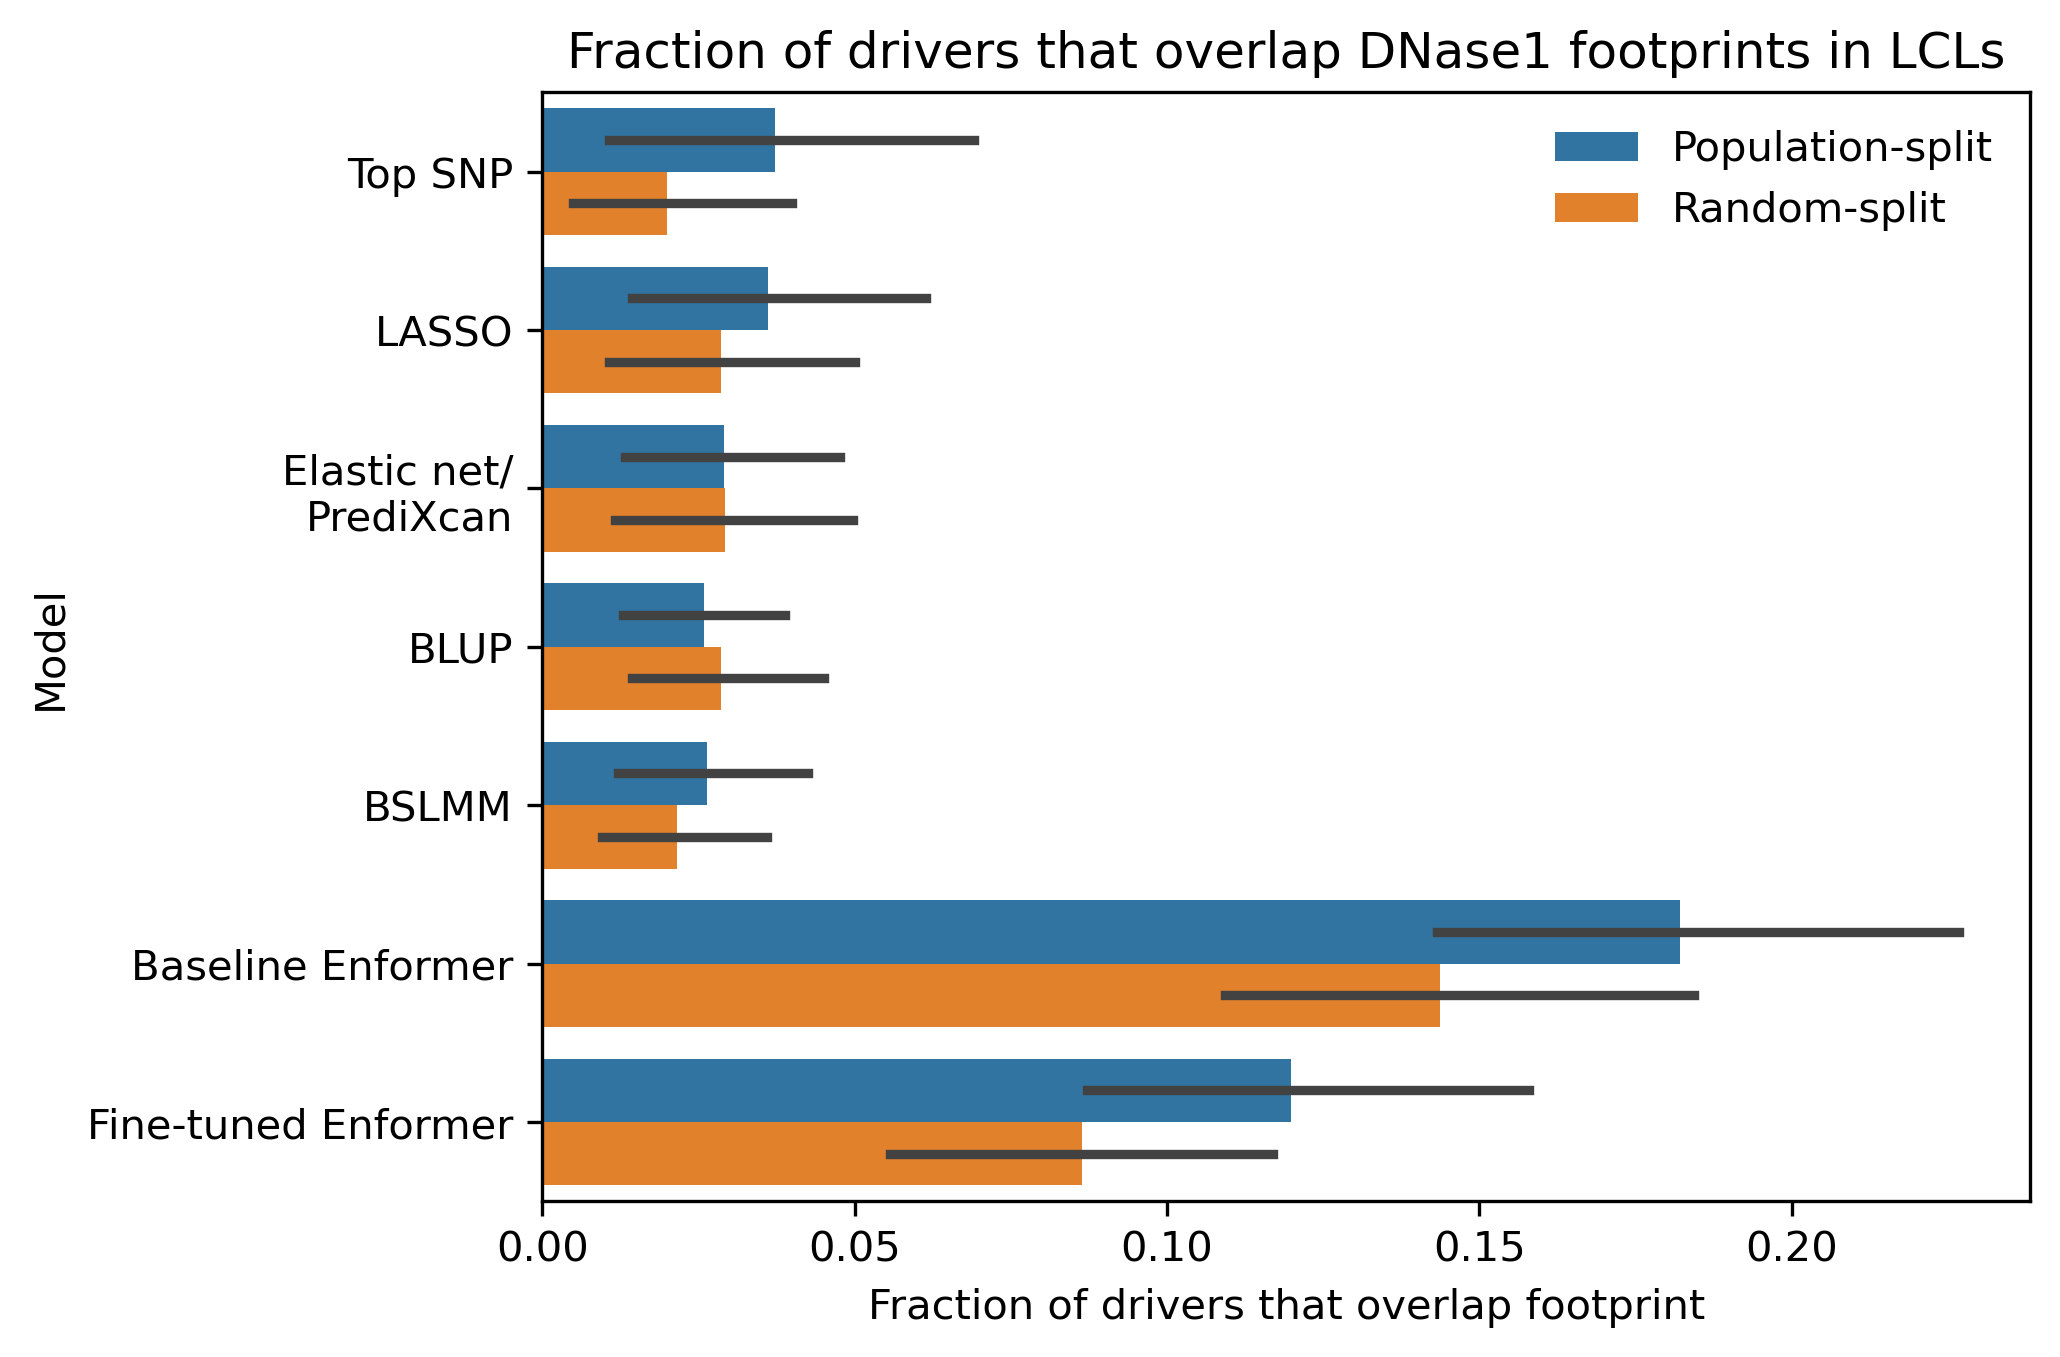

In [67]:
fig, ax = plt.subplots(dpi=300)
sns.barplot(
    y="model",
    x="overlaps_footprint",
    hue="gene_class",
    data=drivers_df,
    estimator="mean",
    errorbar=("ci", 95),
    ax=ax,
)
ax.legend(title="", frameon=False)
ax.set_xlabel("Fraction of drivers that overlap footprint")
ax.set_ylabel("Model")
ax.set_title("Fraction of drivers that overlap DNase1 footprints in LCLs")

plt.show()
